In [1]:
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import itertools
from IPython.core.display import display, HTML, Image
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
f = '../data/googleimages.csv'
I = pd.read_csv(f, index_col=0)

In [3]:
I.head()

,doc,url,category,abroad,abstract,abundance,accessory,accident,accomplishment,achievement,...,written report,yacht,yarn,yes,young,youth,zen,zip up,zombie,zoo
0,1. .jpg,https://encrypted-tbn0.gstatic.com/images?q=tb...,sports,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1. 118783_bg.jpg,https://encrypted-tbn0.gstatic.com/images?q=tb...,fashion,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1. 175px-juan_peron_con_banda_de_presidente.jpg,https://encrypted-tbn0.gstatic.com/images?q=tb...,politics,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1. 200px-shipwreck_beach_-_western_coast_of_za...,https://encrypted-tbn0.gstatic.com/images?q=tb...,countries,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1. 2017-men-039-s-casual-shoes-trend-korea-spr...,https://encrypted-tbn0.gstatic.com/images?q=tb...,fashion,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Naive implementation of Naive Bayes

$$
P(class \mid features) = P(class)P(feature \mid class)
$$

In [4]:
size = int(I.shape[0]*0.8)
train, test = I.iloc[:size], I.iloc[size:]

### Priors

In [5]:
categories = train.category.unique()

In [6]:
categories

array(['sports', 'fashion', 'politics', 'countries'], dtype=object)

In [7]:
K = {}
for c in categories:
    K[c] = train[train.category == c]

In [8]:
priors = np.array([K[c].shape[0] for c in categories])

In [9]:
priors = priors / priors.sum()

In [10]:
priors

array([0.19422424, 0.19082673, 0.26613817, 0.34881087])

### Likelihood

In [11]:
models = {}
for c in categories:
    models[c] = K[c][K[c].columns.difference(['doc', 'url', 'category'])].sum() + 1
for c, m in models.items():
    models[c] = m / m.sum()

In [12]:
train_true = train.category.values
test_true = test.category.values

In [13]:
train_pred, test_pred = [], []
for i, row in train[train.columns.difference([
    'doc', 'url', 'category'])].iterrows():
    predictions = np.ones(len(categories))
    for k, _ in [(x, y) for x, y in row.items() if y > 0]:
        for j, z in enumerate(categories):
            predictions[j] *= models[z][k]
    pred = np.argmax(predictions * priors)
    train_pred.append(categories[pred])
for i, row in test[test.columns.difference([
    'doc', 'url', 'category'])].iterrows():
    predictions = np.ones(len(categories))
    for k, _ in [(x, y) for x, y in row.items() if y > 0]:
        for j, z in enumerate(categories):
            predictions[j] *= models[z][k]
    pred = np.argmax(predictions * priors)
    test_pred.append(categories[pred])

In [14]:
def cm_plot(ax, classes, CM, title, figure):
    im = ax.imshow(CM, interpolation='nearest', cmap=plt.cm.Blues)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    figure.colorbar(im, cax=cax, orientation='vertical')
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=90, fontsize=12)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes, rotation=0, fontsize=12)
    ax.set_title(title, fontsize=16)
    thresh = CM.max() / 2.
    for i, j in itertools.product(range(CM.shape[0]), range(CM.shape[1])):
        ax.text(j, i, CM[i, j], horizontalalignment="center",
                 color="white" if CM[i, j] > thresh else "black", fontsize=12)
    ax.set_ylabel('True label', fontsize=16)
    ax.set_xlabel('Predicted label', fontsize=16)

In [15]:
cm_train = metrics.confusion_matrix(train_true, train_pred, labels=categories)
cm_test = metrics.confusion_matrix(test_true, test_pred, labels=categories)

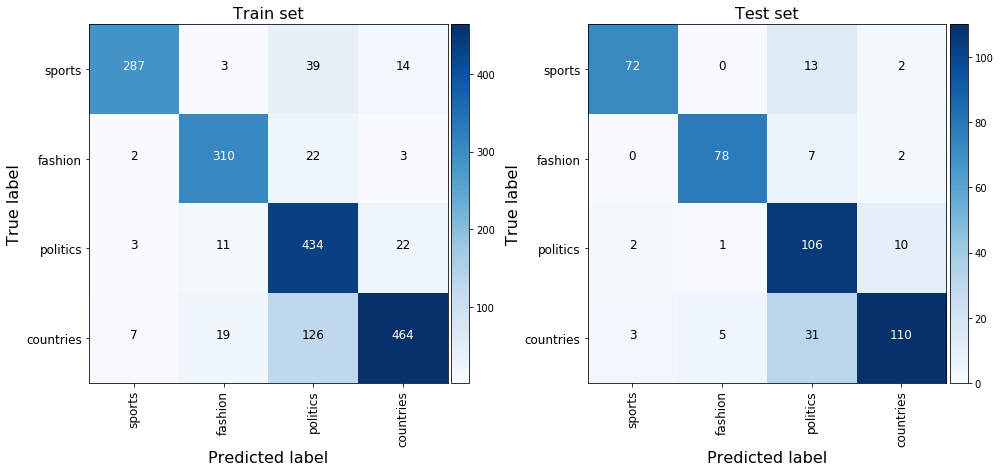

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
cm_plot(axes[0], categories, cm_train, 'Train set', fig)
cm_plot(axes[1], categories, cm_test, 'Test set', fig)
plt.tight_layout()
plt.show()

## Visualize results

In [17]:
images = {'image': [], 'true': [], 'predicted': [], 'url': []}
for j, (i, row) in enumerate(test.iterrows()):
    images['image'].append('<img src="{}">'.format(row.url))
    images['true'].append(row.category)
    images['predicted'].append(test_pred[j])
    images['url'].append(row.url)

In [18]:
rows = []
for i, image in enumerate(images['image']):
    row = '<tr><td>{}</td><td>{}</td><td>{}</td></tr>'.format(
        image, images['true'][i], images['predicted'][i]
    )
    rows.append(row)

In [19]:
table = "<table><tr><th>{}</th><th>{}</th><th>{}</th></tr>{}</table>".format(
    'image', 'true', 'predicted', "".join(rows)
)

In [20]:
display(HTML(table))

image,true,predicted
,fashion,fashion
,sports,politics
,politics,politics
,countries,countries
,sports,politics
,fashion,fashion
,sports,sports
,politics,politics
,countries,countries
,countries,countries
